# User-item embeddings

## Problem setup
Consider 4 users $(u_k){k=0,\ldots,3}$ and 4 items $(i_k){k=0,\ldots,3}$, each represented by a 2D embedding, $U, I \in \mathbb{R}^{4 \times 2}$. We randomly sample 100 pairs from $[u_0, i_0], [u_1, i_1], [u_2, i_2], [u_3, i_3]$. The objective is to train the model so that the embeddings minimize the loss function: $$ L = \text{min}_{\text{k} \in \text{all purchases}} ||U_k - I_k||^2 $$ which is the $L^2$ distance between the user and item embeddings for all observed purchases.

We start with the simple case where, for all $k$, each user embedding $U_k = U[k,:]$ is paired with its corresponding item embedding $I_k=I[k,:]$ as a positive pair. We will first train the model using only these positive pairs, without considering any negative pairs.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Problem setup
n_clients = 8
n_products = 8
embedding_dim = 2

np.random.seed(42)
tf.random.set_seed(42)

In [30]:
# Generate 100 positive pairs (each user only with their corresponding item)
pairs = np.array([[i,i] for i in range(n_clients)] * 25)
np.random.shuffle(pairs)
user_ids = pairs[:, 0]
product_ids = pairs[:, 1]

In [31]:
# Build the model to minimize L2 distance between user and item embeddings
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_embedding = tf.keras.layers.Embedding(input_dim=n_clients, output_dim=embedding_dim, name="user_emb")(user_input)
product_input = tf.keras.layers.Input(shape=(1,), name="product")
product_embedding = tf.keras.layers.Embedding(input_dim=n_products, output_dim=embedding_dim, name="prod_emb")(product_input)

# L2 distance
def l2_distance(inputs):
    u, i = inputs
    return tf.reduce_sum(tf.square(u - i), axis=-1, keepdims=True)

l2_dist = tf.keras.layers.Lambda(l2_distance)([user_embedding, product_embedding])
model = tf.keras.Model(inputs=[user_input, product_input], outputs=l2_dist)
model.compile(optimizer='adam', loss='mse')

# Training
model.fit([user_ids, product_ids], np.zeros(len(user_ids)), epochs=1000, batch_size=16, verbose=0)

In [32]:
# Extract embeddings
M = model.get_layer("user_emb").get_weights()[0]
I = model.get_layer("prod_emb").get_weights()[0]

# Distance matrix
distance_matrix = np.zeros((n_clients, n_products))
for k in range(n_clients):
    for i in range(n_products):
        distance_matrix[k, i] = np.linalg.norm(M[k] - I[i])

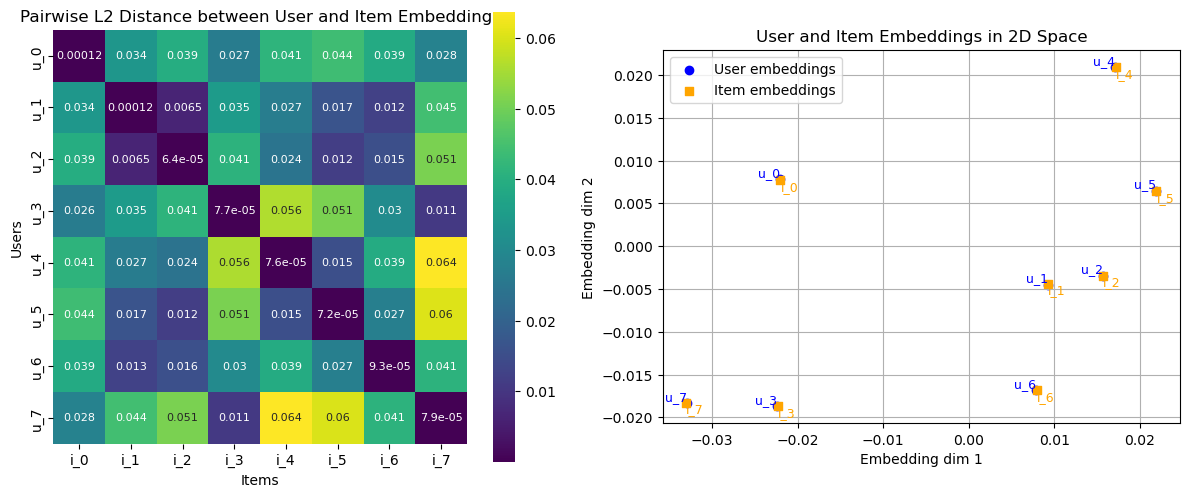

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Heatmap subplot
sns.heatmap(
    distance_matrix,
    annot=True,
    cmap="viridis",
    xticklabels=[f"i_{i}" for i in range(n_products)],
    yticklabels=[f"u_{k}" for k in range(n_clients)],
    annot_kws={"fontsize":8},
    ax=axes[0],
    square=True
)
axes[0].set_title("Pairwise L2 Distance between User and Item Embeddings")
axes[0].set_xlabel("Items")
axes[0].set_ylabel("Users")
axes[0].set_aspect('equal', adjustable='box')

# Embedding scatter subplot
axes[1].scatter(M[:, 0], M[:, 1], c='blue', label='User embeddings')
axes[1].scatter(I[:, 0], I[:, 1], c='orange', label='Item embeddings', marker='s')
for idx, (x, y) in enumerate(M):
    axes[1].text(x, y, f'u_{idx}', fontsize=9, ha='right', va='bottom', color='blue')
for idx, (x, y) in enumerate(I):
    axes[1].text(x, y, f'i_{idx}', fontsize=9, ha='left', va='top', color='orange')
axes[1].set_title("User and Item Embeddings in 2D Space")
axes[1].set_xlabel("Embedding dim 1")
axes[1].set_ylabel("Embedding dim 2")
axes[1].legend()
axes[1].grid(True)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

Let's now consider the case where we only embed the users' vectors. the training datasets remains the same.

In [34]:
item_to_user = np.array([i for i in range(n_clients)]) 
# for example [0, 2, 4, 6, 1, 3, 5, 7]
# This maps item i to user item_to_user[i], where item_to_user[i] = (i + 2) % n_clients

# Generate 100 positive pairs (user, item) where user u is paired with item i, and i is mapped to user item_to_user[i]
pairs = np.array([[u, i] for u, i in zip(item_to_user, np.arange(n_clients))] * 25)
np.random.shuffle(pairs)
user_ids = pairs[:, 0]
product_ids = pairs[:, 1]

# Only user embeddings: represent item i as user embedding item_to_user[i]
user_input = tf.keras.layers.Input(shape=(1,), name="user")
item_input = tf.keras.layers.Input(shape=(1,), name="item")

user_embedding_layer = tf.keras.layers.Embedding(input_dim=n_clients, output_dim=embedding_dim, name="user_emb")
user_embedding = user_embedding_layer(user_input)

# Map item index to user index
item_to_user_tf = tf.constant(item_to_user, dtype=tf.int32)
item_user_index = tf.keras.layers.Lambda(lambda x: tf.gather(item_to_user_tf, tf.cast(x, tf.int32)))(item_input)
item_embedding = user_embedding_layer(item_user_index)

def l2_distance(inputs):
    u, i = inputs
    return tf.reduce_sum(tf.square(u - i), axis=-1, keepdims=True)

l2_dist = tf.keras.layers.Lambda(l2_distance)([user_embedding, item_embedding])
model = tf.keras.Model(inputs=[user_input, item_input], outputs=l2_dist)
model.compile(optimizer='adam', loss='mse')

# Training
model.fit([user_ids, product_ids], np.zeros(len(user_ids)), epochs=1000, batch_size=16, verbose=0)

In [35]:
# Extract embeddings
M = model.get_layer("user_emb").get_weights()[0]

# Distance matrix (between user embeddings, used for both users and items)
distance_matrix = np.zeros((n_clients, n_clients))
for k in range(n_clients):
    for i in range(n_clients):
        distance_matrix[k, i] = np.linalg.norm(M[k] - M[item_to_user[i]])

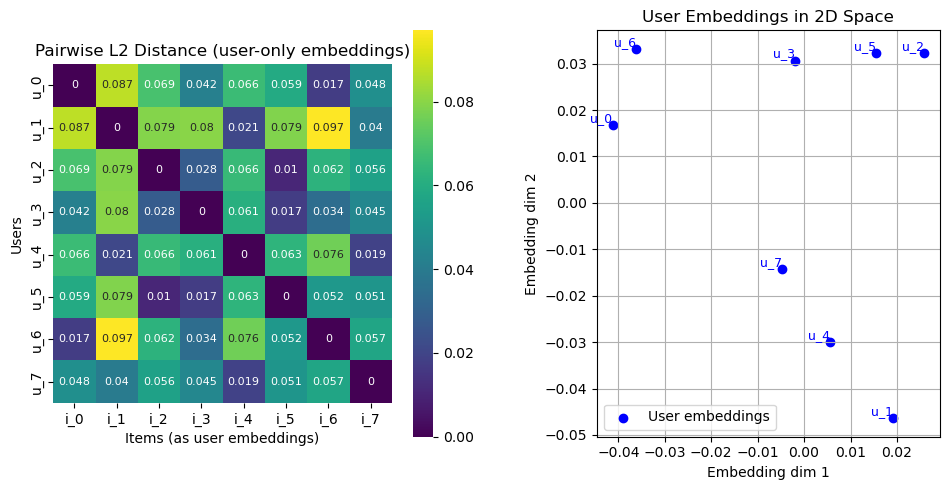

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Heatmap subplot
sns.heatmap(
    distance_matrix,
    annot=True,
    cmap="viridis",
    xticklabels=[f"i_{i}" for i in range(n_clients)],
    yticklabels=[f"u_{k}" for k in range(n_clients)],
    annot_kws={"fontsize":8},
    ax=axes[0],
    square=True  # Ensures the heatmap is square
)
axes[0].set_title("Pairwise L2 Distance (user-only embeddings)")
axes[0].set_xlabel("Items (as user embeddings)")
axes[0].set_ylabel("Users")
axes[0].set_aspect('equal', adjustable='box')  # Keep squares

# Embedding scatter subplot
axes[1].scatter(M[:, 0], M[:, 1], c='blue', label='User embeddings')
for idx, (x, y) in enumerate(M):
    axes[1].text(x, y, f'u_{idx}', fontsize=9, ha='right', va='bottom', color='blue')
axes[1].set_title("User Embeddings in 2D Space")
axes[1].set_xlabel("Embedding dim 1")
axes[1].set_ylabel("Embedding dim 2")
axes[1].legend()
axes[1].grid(True)
axes[1].set_aspect('equal', adjustable='box')  # Keep scatter plot square

plt.tight_layout()
plt.show()

### Discussion
The user embedding matrix is trained to minimize the $L^2$ distance between each user and their corresponding item. In this approach, only user embeddings are learned, and item embeddings are inferred based on the mapping between users and items. This method is valid only when there is a one-to-one mapping between users and items. For more general cases, where the mapping is not one-to-one, it is necessary to learn separate embeddings for both users and items.